### ILQR example
The example shows how to compute the ilqr solution to a 1 dof actuated pendulum. At this point we are only penalizing the control inputs and the deviation from the final state in the overall cost. The ILQR is solving the following optimization problem:

\begin{align*} 
    \min_{\mathbf{u}[\cdot]} \quad & \ell_f(\mathbf{x}[N]) + \sum_{n=0}^{N-1} \ell(\mathbf{x}[n],\mathbf{u}[n]) \\ 
    \text{subject to} \quad & \mathbf{x}[n+1] = {\bf
      f}(\mathbf{x}[n], \mathbf{u}[n]), \quad \forall n\in[0, N-1] \\ & \mathbf{x}[0] = \mathbf{x}_0
\end{align*}

#### Discrete dynamics
We will define, in the following, the symbolic dynamics of the pendulum. For convenience, lambda functions are used for $x_{k+1} = f(u_k, x_k)$ and it's derivatives $A = \frac{\partial f}{\partial x}$ and $B = \frac{\partial f}{\partial u}$

In [ ]:
import numpy as np
import sympy as sp
from sympy.matrices import Matrix

In [ ]:
def symbolic_dynamics_pendulum():
    """Symbolic dynamics for a pendulum

    Returns:
        sympy.Function: f(x.u)
        sympy.Function: df/dx
        sympy.Function: df/du
    """
    m, g, L, theta, theta_dot, u, dt = sp.symbols('m g L theta theta_dot u dt')

    # inputs and states
    inputs = Matrix([u])
    states = Matrix([theta, theta_dot])

    # dynamics for a pendulum of mass m and center of mass L
    # ----------------
    #        |\
    #        | \
    # \theta |->\
    #        |  []
    f = Matrix([theta_dot, (u-m*g*L*sp.sin(theta))/(m*L*L)])

    # discretize the system using euler integration
    f_disc = states + f*dt

    # first derivatives wrt to (x, u)
    f_x = f_disc.jacobian(states) # df/dx
    f_u = f_disc.jacobian(inputs) # df/du

    # second derivatives wrt to (x, u)
    # f_xx = f_x.(states) # d2f/dx2
    # f_uu = f_u.jacobian(states) # d2f/du2

    # define parameters
    parameters = Matrix([m,g,L])

    # create lambdas
    f_func = sp.lambdify((states, inputs, dt, parameters), f_disc)
    f_x_func = sp.lambdify((states, inputs, dt, parameters), f_x)
    f_u_func = sp.lambdify((states, inputs, dt, parameters), f_u)
    # f_xx_func = sp.lambdify((states, inputs, dt, parameters), f_xx)
    # f_uu_func = sp.lambdify((states, inputs, dt, parameters), f_uu)

    # return (f_func, f_x_func, f_u_func, f_xx_func, f_uu_func)
    return (f_func, f_x_func, f_u_func)


#### Iterative LQR class
The ILQR class consist of several key components:
- Rollout - Given an initial state $x_0$ and the initial control trajectory, $u_0 \dots u_{N-1}$, rollout the new states using the discrete dynamics
- Cost computation - Given the state and control trajectories, $x_0 \dots x_{N-1}$ and $u_0 \dots u_{N-1}$, compute the total cost, i.e. stage $\ell$ and final $\ell_f$ costs
- Bellman recursion (Backward pass) - Defining optimality recursively backwards in time with linear approximation of dynamics and quadratic approximation of cost around the a nominal trajectory, we estimate the value function and derive all the feedforward $k$ and feedback $K$ gains.

##### Bellman recursion
The Bellman equation is given by 
\begin{align*} 
V(\mathbf{x}[n]) = & \min_{\mathbf{u}[n]} \quad \ell(\mathbf{x}[n], \mathbf{u}[n])  + V(\mathbf{x}[n+1]) \\
\end{align*}
The full formulation as an optimization problem is given by
\begin{align*}
\min_{\mathbf{u}[n]} \quad & Q(\mathbf{x}[n], \mathbf{u}[n]), \quad \forall n\in[0, N-1] \\
\text{subject to} \quad & Q(\mathbf{x}[n], \mathbf{u}[n]) = \ell(\mathbf{x}[n], \mathbf{u}[n]) + V(\mathbf{x}[n+1]) \\
& V(\mathbf{x}[N]) = \ell_f(x[N]) \\
& \mathbf{x}[n+1] = f(\mathbf{x}[n], \mathbf{u}[n]), \quad \mathbf{x}[0] = \mathbf{x}_0
\end{align*}

##### Taylor expansion of the Q-function's stage cost and the linearized dynamics
Expanding all the stage cost in the Q-function using second order taylor expansion at the nominal state $(\bf{\bar x}, \bf{\bar u}) = (\bf{x - \delta x}, \bf{u - \delta u})$, the quadratized stage cost is
\begin{align*}
\ell(\mathbf{x}[n], \mathbf{u}[n]) \approx \ell(\mathbf{\bar x}[n], \mathbf{\bar u}[n]) + 
\begin{bmatrix} 
\ell_{\mathbf{x},n} \\ 
\ell_{\mathbf{u},n} 
\end{bmatrix}^T \begin{bmatrix} 
\delta \mathbf{x}[n] \\ 
\delta \mathbf{u}[n]
\end{bmatrix} + \frac{1}{2}
\begin{bmatrix} 
\delta \mathbf{x}[n] \\ 
\delta \mathbf{u}[n]
\end{bmatrix}^T \begin{bmatrix} 
\ell_{\mathbf{xx},n} & \ell_{\mathbf{ux},n}^T \\ 
\ell_{\mathbf{ux},n} & \ell_{\mathbf{uu},n} 
\end{bmatrix} \begin{bmatrix} 
\delta \mathbf{x}[n] \\ 
\delta \mathbf{u}[n]
\end{bmatrix}
\end{align*}
The linearized dynamics is given by
\begin{align*}
\mathbf{x}[n+1] = \mathbf{f}(\mathbf{x}[n], \mathbf{u}[n]) \approx \mathbf{f}(\mathbf{\bar x}[n], \mathbf{\bar u}[n]) + 
\begin{bmatrix}\mathbf{f}_{\mathbf{x},n} & \mathbf{f}_{\mathbf{u},n} \end{bmatrix}
\begin{bmatrix}\delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}
\end{align*}
where $\ell(\mathbf{\bar x}[n], \mathbf{\bar u}[n])$ and $\mathbf{f}(\mathbf{\bar x}[n], \mathbf{\bar u}[n])$. $\ell_\mathbf{x}, \ell_\mathbf{u}, f_\mathbf{x}, f_\mathbf{u}$ are gradients and jacobians evaluated at $(\mathbf{\bar x}, \mathbf{\bar u})$. $\ell_\mathbf{xx}, \ell_\mathbf{ux}, \ell_\mathbf{uu}$ are the Hessians at $(\mathbf{\bar x}, \mathbf{\bar u})$

##### Taylor expansion of the Q-function's value function
For the second term, $V(\mathbf{x}[n+1])$, the second order expansion yields
\begin{align*}
V(\mathbf{x}[n+1]) \approx V_{n+1} + V_{\mathbf{x}, n+1}^T \delta \mathbf{x}[n+1] + \frac{1}{2} \delta \mathbf{x}[n+1]^T V_{\mathbf{xx}, n+1}^T \delta \mathbf{x}[n+1]
\end{align*}
where $\delta \mathbf{x}[n+1]$ can be backed out from the linearized dynamics
\begin{align*}
\delta \mathbf{x}[n+1]  & = \mathbf{x}[n+1] - \mathbf{\bar x}[n+1] \\
                        & = \mathbf{f}(\mathbf{\bar x}[n], \mathbf{\bar u}[n]) + 
\begin{bmatrix}\mathbf{f}_{\mathbf{x},n} & \mathbf{f}_{\mathbf{u},n} \end{bmatrix}
\begin{bmatrix}\delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} - \mathbf{\bar x}[n+1] \\
                        & = \begin{bmatrix}\mathbf{f}_{\mathbf{x},n} & \mathbf{f}_{\mathbf{u},n} \end{bmatrix}
\begin{bmatrix}\delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}
\end{align*}

##### Q-function
Now that we have expanded all the terms, we have
\begin{align*}
Q(\mathbf{x}[n], \mathbf{u}[n]) & = \ell(\mathbf{x}[n], \mathbf{u}[n]) + V(\mathbf{x}[n+1]) \\
                                & \approx \ell_n + 
\begin{bmatrix} 
\ell_{\mathbf{x},n} \\ 
\ell_{\mathbf{u},n} 
\end{bmatrix}^T \begin{bmatrix} 
\delta \mathbf{x}[n] \\ 
\delta \mathbf{u}[n]
\end{bmatrix} + \frac{1}{2}
\begin{bmatrix} 
\delta \mathbf{x}[n] \\ 
\delta \mathbf{u}[n]
\end{bmatrix}^T \begin{bmatrix} 
\ell_{\mathbf{xx},n} & \ell_{\mathbf{ux},n}^T \\ 
\ell_{\mathbf{ux},n} & \ell_{\mathbf{uu},n} 
\end{bmatrix} \begin{bmatrix} 
\delta \mathbf{x}[n] \\ 
\delta \mathbf{u}[n]
\end{bmatrix} \\
                                & \quad + V_{n+1} + V_{\mathbf{x}, n+1}^T \delta \mathbf{x}[n+1] + \frac{1}{2} \delta \mathbf{x}[n+1]^T V_{\mathbf{xx}, n+1} \delta \mathbf{x}[n+1] \\
                                & = Q_{n} + 
                                [\ell_{\mathbf{x},n}^T \quad \ell_{\mathbf{u},n}^T] \begin{bmatrix}\delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} + 
                                V_{\mathbf{x}, n+1}^T [\mathbf{f}_{\mathbf{x},n} \quad \mathbf{f}_{\mathbf{u},n}] \begin{bmatrix}\delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} \\
                                & \quad + \frac{1}{2} \begin{bmatrix}\delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}^T \begin{bmatrix} \mathbf{f}_{\mathbf{x},n}^T \\ \mathbf{f}_{\mathbf{u},n}^T \end{bmatrix} V_{\mathbf{xx}, n+1} \begin{bmatrix}\mathbf{f}_{\mathbf{x},n} & \mathbf{f}_{\mathbf{u},n} \end{bmatrix}
\begin{bmatrix}\delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} \\
                                & = Q_{n} + [Q_{\mathbf{x},n}^T \quad Q_{\mathbf{u},n}^T] \begin{bmatrix}\delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix} + 
                                \frac{1}{2} \begin{bmatrix}\delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}^T \begin{bmatrix} Q_{\mathbf{xx},n} & Q_{\mathbf{ux},n}^T \\ 
                                Q_{\mathbf{ux},n} & Q_{\mathbf{uu},n} \end{bmatrix}
                                \begin{bmatrix}\delta \mathbf{x}[n] \\ \delta \mathbf{u}[n] \end{bmatrix}
\end{align*}

**Note** Here, we made an LQ approximation to the dynamics and the cost. In DDP, we directly perform the second order taylor expansion of the Bellman backup equation. This results in additional terms in the $Q_\mathbf{xx}, Q_\mathbf{ux}, Q_\mathbf{uu}$ expressions. Reference: https://people.eecs.berkeley.edu/~pabbeel/cs287-fa19/slides/Lec5-LQR.pdf

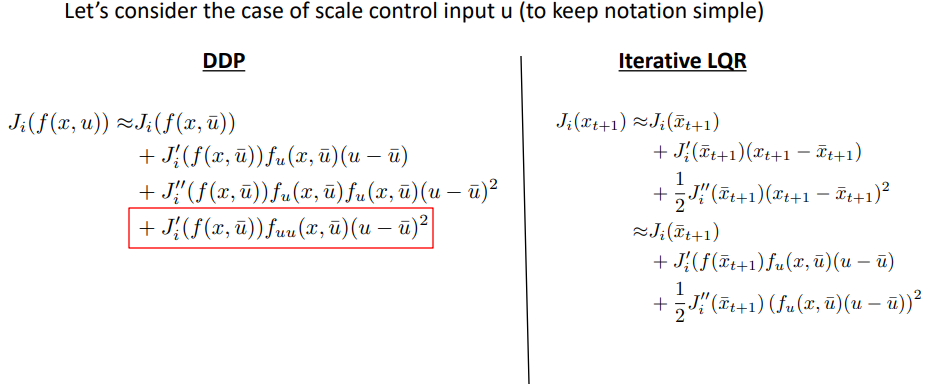

##### Optimal control/policy
Now that we have the Q-function, we can find the optimal policy by optimizing over $\mathbf{u}[n]$
\begin{align*}
\min_{\mathbf{u}[n]} & \quad Q(\mathbf{x}[n], \mathbf{u}[n])
\end{align*}
This is equivalent to optimizing over $\delta \mathbf{u}[n]$ for $\delta Q = Q(\mathbf{x}[n], \mathbf{u}[n]) - Q_n$. Setting $\frac{\partial \delta Q}{\partial \delta \mathbf{u}[n]} = 0$ gives
\begin{align*}
Q_{\mathbf{u},n} + Q_{\mathbf{ux},n} \delta \mathbf{x}[n] + Q_{\mathbf{uu},n} \delta \mathbf{u}[n]^{*} & = 0 \\
\delta \mathbf{u}[n]^{*} & = -Q_{\mathbf{uu},n}^{-1} (Q_{\mathbf{u},n} + Q_{\mathbf{ux},n} \delta \mathbf{x}[n])
\end{align*}
The feedforward and feedback gains are $k_n = -Q_{\mathbf{uu},n}^{-1} Q_{\mathbf{u},n}$ and $K_n = -Q_{\mathbf{uu},n}^{-1} Q_{\mathbf{ux},n}$. The modification in the control trajectory is thus $\delta \mathbf{u}[n]^* = k_n + K_n \delta \mathbf{x}[n]$ where $\mathbf{u}[n] = \mathbf{\bar u}[n] + \delta \mathbf{u}[n]^*$

##### Value updates
Substituting this optimal control modification into the expanded Q-function described above, we have:
\begin{align*}
\delta Q_n |_{\delta \mathbf{u}[n] = \delta \mathbf{u}[n]^*} & = [Q_{\mathbf{x},n}^T \quad Q_{\mathbf{u},n}^T] \begin{bmatrix}\delta \mathbf{x}[n] \\ k_n + K_n \delta \mathbf{x}[n] \end{bmatrix} + 
                                \frac{1}{2} \begin{bmatrix}\delta \mathbf{x}[n] \\ k_n + K_n \delta \mathbf{x}[n] \end{bmatrix}^T \begin{bmatrix} Q_{\mathbf{xx},n} & Q_{\mathbf{ux},n}^T \\ 
                                Q_{\mathbf{ux},n} & Q_{\mathbf{uu},n} \end{bmatrix}
                                \begin{bmatrix}\delta \mathbf{x}[n] \\ k_n + K_n \delta \mathbf{x}[n] \end{bmatrix}
\end{align*}

Along the state trajectory with $\delta \mathbf{x}[n] = 0$, the improvement in value is therefore
\begin{align*}
\Delta V_n = \delta Q_n |_{\delta \mathbf{x}[n] = 0} = Q_{\mathbf{u},n}^T k_n + \frac{1}{2} k_n^T Q_{\mathbf{u},n} k_n
\end{align*}

Also, taking the taylor expansion of the value function as before, we have $\delta V_n = V_{\mathbf{x}, n}^T \delta \mathbf{x}[n] + \frac{1}{2} \delta \mathbf{x}[n]^T V_{\mathbf{xx}, n}^T \delta \mathbf{x}[n]$. By definition, $\delta V_n = \delta Q_n |_{\delta \mathbf{u}[n] = \delta \mathbf{u}[n]^*}$
\begin{align*}
V_{\mathbf{x}, n} &= Q_{\mathbf{x},n} + K_n^T Q_{\mathbf{uu},n} k_n + K_n^T Q_{\mathbf{u},n} + Q_{\mathbf{ux},n}^T k_n \\
V_{\mathbf{xx}, n} &= Q_{\mathbf{xx},n} + K_n^T Q_{\mathbf{uu},n} K_n + K_n^T Q_{\mathbf{ux},n} + Q_{\mathbf{ux},n}^T K_n
\end{align*}

In [ ]:
class ilqr:
    def __init__(self, init_state, target_state, initial_input_guess, dt, start_time, end_time, f_discrete, f_x, f_u, Q_k, R_k, Q_T, parameters, n_iterations):
        """Initialization of ILQR

        Args:
            init_state (ndarray): Initial state
            target_state (ndarray): Target state
            initial_input_guess (ndarray): Initial guess for ilqr
            dt (double): Sampling time for discrete system
            start_time (double): Starting time, defaults to 0 for a single trajectory
            end_time (double): Ending time, defaults to final time for a single trajectory
            f_discrete (sympy.Matrix): Symbolic representation of the x_{k_+1} = f(x_k, u_k)
            f_x (sympy.Matrix): df_dx term of the linearized system
            f_u (sympy.Matrix): df_du term of the linearized system
            Q_k (ndarray): Weights for states in the running cost
            R_k (ndarray): Weights for inputs in the running cost
            Q_T (ndarray): Weights for states in the terminal cost
            parameters (ndarray): Parameters of the system
            n_iterations (double): Maximum interations for ilqr
        """
        # states
        self.init_state_ = init_state
        self.target_state_ = target_state
        self.inputs_ = initial_input_guess
        self.n_states_ = np.shape(init_state)[0] # The dimensions of the state vector
        self.n_inputs_ = np.shape(initial_input_guess)[1] # The dimension of the control vector

        # timing
        self.dt_ = dt
        self.start_time_ = start_time
        self.end_time_ = end_time
        self.time_span_ = np.arange(start_time, end_time, dt).flatten()
        self.n_timesteps_ = np.shape(self.time_span_)[0]

        # dynamics
        self.f_ = f_discrete
        self.f_x_ = f_x
        self.f_u_ = f_u

        # weighting for loss function, i.e. L = x_T^T Q_T x_T + sum of (x_k^T Q_k x_k + u_k^T R_k u_k)
        self.Q_k_ = Q_k # Weight for state vector
        self.R_k_ = R_k # Weight for control vector
        self.Q_T_ = Q_T # Weight for terminal state
        self.parameters_ = parameters

        # max iterations to run
        self.n_iterations_ = n_iterations

        # costs
        self.expected_cost_reduction_ = 0
        self.expected_cost_reduction_grad_ = 0
        self.expected_cost_reduction_hess_ = 0

    def rollout(self):
        """Rollout of the simulated system given an initial state

        Returns:
            ndarray: States trajectory from the rollout
            ndarray: Inputs trajectory from the rollout
        """
        # we store states and inputs as:
        # state = [., x_1, x_2, ..., x_N]
        # input =    [u_0, u_1, ..., u_{N-1}]
        # the first value in state is understood as self.init_state_
        states = np.zeros((self.n_timesteps_+1, self.n_states_)) # including initial state, x_0 to x_N
        inputs = np.zeros((self.n_timesteps_, self.n_inputs_)) # u_0 to u_{N-1}

        # TODO: store first state, x0 into states
        states[0,:] = self.init_state_

        # integrate dynamics
        current_state = self.init_state_
        for i in range(0, self.n_timesteps_): # 0 to N-1
            current_input = self.inputs_[i,:] # u_k
            next_state = self.f_(current_state, current_input, self.dt_, self.parameters_).flatten() # x_{k+1} = f(x_k, u_k) 
            # store both u_k and x_{k+1}
            states[i+1,:] = next_state
            inputs[i,:] = current_input
            # update current state
            current_state = next_state

        # store trajectories
        self.states_ = states
        self.inputs_ = inputs

        return states, inputs

    def compute_cost(self, states, inputs):
        """Computes the cost from all the terms, i.e. dynamics and cost as well as their derivatives:
        f_x, f_u, f_xx, f_ux, f_uu, 
        l_x, l_u, l_xx, l_ux, l_uu

        Args:
            states (ndarray): State trajectory
            inputs (ndarray): Input trajectory

        Returns:
            double: Total cost, i.e. terminal cost + running cost
        """
        # accumulate cost to go
        total_cost = 0
        for i in range(0, self.n_timesteps_):
            current_x = states[i,:]
            current_u = inputs[i,:].flatten()
            current_cost = current_u.T @ self.R_k_ @ current_u
            total_cost = total_cost + current_cost
        # add terminal cost
        terminal_diff = (states[-1,:] - self.target_state_).flatten()
        terminal_cost = terminal_diff.T @ self.Q_T_ @ terminal_diff
        total_cost = total_cost + terminal_cost

        return total_cost

    def backward_pass(self):
        """Backward pass of iLQR

        Returns:
            ndarray: feedforward gain, k
            ndarray: feedback gain, K
            double: expected cost reduction
        """
        # starting from the last state
        V_xx = self.Q_T_ # since V_N = x_T^T Q_T x_T, V_xx(N) = Q_T_
        end_difference = (self.states_[-1, :] - self.target_state_).flatten()
        end_difference = end_difference.flatten()
        V_x = self.Q_T_ @ end_difference # V_x(N)

        # initialize control modifications to be stored
        k_trj = np.zeros((self.n_timesteps_, self.n_inputs_)) # (8b)
        K_trj = np.zeros((self.n_timesteps_, self.n_inputs_, self.n_states_)) # (8b)

        # initialize cost reduction
        expected_cost_reduction = 0
        expected_cost_reduction_grad = 0
        expected_cost_reduction_hess = 0

        # looping backwards from N-1 to 1 using initial value of V_{N}
        for i in reversed(range(0, self.n_timesteps_)):
            # current variables
            current_x = self.states_[i,:]
            current_u = self.inputs_[i,:]

            # updates to partial derivatives of cost function
            l_xx = self.Q_k_
            l_uu = self.R_k_

            # l_ux = np.zeros((self.n_inputs_, self.n_states_))
            l_x = self.Q_k_ @ np.zeros(self.n_states_).flatten()
            l_u = self.R_k_ @ (current_u).flatten()

            # get jacobian of discrete dynamics
            f_x = self.f_x_(current_x, current_u, self.dt_, self.parameters_) # V'_x
            f_u = self.f_u_(current_x, current_u, self.dt_, self.parameters_) # V'_u
    
            # all the Q vector/matrices
            Q_x = l_x + f_x.T @ V_x # (5a)
            Q_u = l_u + f_u.T @ V_x # (5b)
            Q_ux = f_u.T @ V_xx @ f_x # (5c)
            Q_uu = l_uu + f_u.T @ V_xx @ f_u # (5d)
            Q_xx = l_xx + f_x.T @ V_xx @ f_x # (5e)

            # compute and store gains
            kSingValThreshold = 1e-4
            (_,s,_) = np.linalg.svd(Q_uu)
            if (np.min(s) < kSingValThreshold):
                print("Q_uu is non-singular")
            Q_uu_inv = np.linalg.inv(Q_uu) # TODO: this can be singular, try using (9)
            k = -Q_uu_inv @ Q_u # (6)
            K = -Q_uu_inv @ Q_ux # (6)

            k_trj[i,:] = k 
            K_trj[i,:,:] = K 

            # update the expected reduction (11a), delta V
            # similar to equation of delta J(\alpha)
            current_cost_reduction_grad = -Q_u.T @ k
            current_cost_reduction_hess = -(0.5 * k.T @ (Q_uu) @ (k))
            current_cost_reduction = current_cost_reduction_grad + current_cost_reduction_hess

            expected_cost_reduction_grad += current_cost_reduction_grad
            expected_cost_reduction_hess += current_cost_reduction_hess
            expected_cost_reduction += current_cost_reduction

            # update hessian and gradient of value function for the next iteration
            V_x = Q_x + K.T @ Q_uu @ k + K.T @ Q_u + Q_ux.T @ k # (11b)
            V_xx = Q_xx + K.T @ Q_uu @ K + K.T @ Q_ux + Q_ux.T @ K # (11c)

        # store values
        self.expected_cost_reduction_grad_ = expected_cost_reduction_grad
        self.expected_cost_reduction_hess_ = expected_cost_reduction_hess
        self.expected_cost_reduction_ = expected_cost_reduction

        # store gains
        self.k_feedforward_ = k_trj
        self.K_feedback_ = K_trj

        return (k_trj, K_trj, expected_cost_reduction)

    def forward_pass(self, alpha):
        """Forward pass of iLQR

        Args:
            alpha (double): learning rate (\alpha)
            
        Returns:
            ndarray: updated states, \hat x (8a,b,c)
            ndarray: updated inputs, \hat u (12)
        """
        # initialize before integration
        states = np.zeros((self.n_timesteps_ + 1, self.n_states_)) # to store updated trajectory
        inputs = np.zeros((self.n_timesteps_, self.n_inputs_)) # to store updated inputs
        current_state = self.init_state_

        # initialize and start integrating going forward for:
        # state = [., x_1, x_2, ..., x_N]
        # input =    [u_0, u_1, ..., u_{N-1}]
        states[1,:] = current_state # (8a), assume that index 0 contains x_0
        for i in range(0, self.n_timesteps_):
            # use current gains
            current_feedforward = alpha * self.k_feedforward_[i,:] # (12), \hat represents the updated variables
            current_feedback = self.K_feedback_[i,:,:] @ (current_state - self.states_[i,:]) # (12)
            current_input = self.inputs_[i,:] + current_feedforward + current_feedback # (12)
            # simulate
            next_state = self.f_(current_state, current_input, self.dt_, self.parameters_).flatten()
            # store states and inputs
            states[i+1,:] = next_state
            inputs[i,:] = current_input.flatten()
            
            # update states
            current_state = next_state

        return (states, inputs)

    def solve(self):
        """Solve all iLQR problem

        Returns:
            ndarray: Solved states
            ndarray: Solved inputs
            ndarray: Solved feedforward gains
            ndarray: Solved feedback gains
            double: final cost
        """        
        # rollout with the initial guess
        (states, inputs) = self.rollout()

        # compute initial cost
        current_cost = self.compute_cost(states, inputs)
        
        # setup traces
        cost_trace = [current_cost]

        # learning parameters
        learning_speed = 0.95 # this can be modified, 0.95 is very slow
        low_alpha = 0.05 # if learning rate drops to this value stop the optimization
        low_expected_reduction = 1e-3 # determines optimality
        
        armijo_threshold = 0.1 # determines if current line search solve is good (labelled as 'c' in (13))

        # start solving
        for i in range(0, self.n_iterations_):
            print("Starting iteration: {}".format(i))
            # backward pass
            (k_feedforward, K_feedback, expected_reduction) = self.backward_pass()

            # check for convergence
            if (np.abs(expected_reduction) < low_expected_reduction):
                # there is no further reduction, end the optimization
                print("Stopping optimization and accepting solution, abs_expected_reduction = {:.4f}".format(np.abs(expected_reduction)))
                break
            
            # start forward pass and line search with \alpha = 1
            alpha = 1
            armijo_flag = False
            # execute line search until the armijo condition is met (for now just check if the cost decreased)
            # TODO: add real armijo condition
            while (alpha > low_alpha and armijo_flag == False):
                # compute forward pass
                (new_states, new_inputs) = self.forward_pass(alpha)
                new_cost = self.compute_cost(new_states, new_inputs)

                # compute armijo condition
                cost_difference = (current_cost - new_cost)
                expected_cost_red = alpha * (self.expected_cost_reduction_grad_ + alpha*self.expected_cost_reduction_hess_)
                armijo_flag = (cost_difference / expected_cost_red) > armijo_threshold # z (13)

                print("Rate = {:.4f}, cost = {:.4f}, dcost = {:.4f}, expected cost red = {:.4f}, armijo = {}".format(alpha, new_cost, cost_difference, expected_cost_red, armijo_flag))

                if (armijo_flag):
                    # accept new trajectory if armijo condition is met
                    current_cost = new_cost
                    cost_trace.append(current_cost)
                    self.states_ = new_states
                    self.inputs_ = new_inputs
                else:
                    # no improvement, decrease learning rate and restart forward pass
                    alpha = learning_speed*alpha

            # if we exited while loop due to (alpha > low_alpha) being false
            if (alpha < low_alpha):
                print("Stopping optimization due to low learning rate")
                break

        # return the current trajectory
        states = self.states_
        inputs = self.inputs_

        return states, inputs, k_feedforward, K_feedback, cost_trace


In [ ]:
# import dynamics
(f,f_x,f_u) = symbolic_dynamics_pendulum()

# initialize timing
dt = 0.005
start_time = 0
end_time = 5
time_span = np.arange(start_time, end_time, dt)

# set states (start and end states are at rest)
n_states = 2 # position and velocity
n_inputs = 1 # inputs to the system
init_state = np.array([0,0])
target_state = np.array([np.pi,0])

# initial guess
initial_input_guess = 0.1*np.ones((time_span.shape[0], n_inputs))

# define weights
Q_k = np.zeros((n_states, n_states)) # just find a valid trajectory first
R_k = 0.001*np.eye(n_inputs)
Q_T = 100*np.eye(n_states)

# physical parameters
mass = 1
gravity = 9.8
pendulum_length = 1
parameters = np.array([mass, gravity, pendulum_length])

# iterations
n_iterations = 50

# ilqr
ilqr = ilqr(init_state, target_state, initial_input_guess, dt, start_time, end_time, f, f_x, f_u, Q_k, R_k, Q_T, parameters, n_iterations)

# solve for swing up
(states, inputs, k_feedforward, K_feedback, cost_trace) = ilqr.solve()

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.subplots(figsize=(10,6))

# plot results
plt.subplot(2, 2, 1)
plt.plot(cost_trace)
plt.xlabel('# Iteration')
plt.ylabel('Total cost')
plt.title('Cost trace')

plt.subplot(2, 2, 2)
delta_opt = (np.array(cost_trace) - cost_trace[-1])
plt.plot(delta_opt)
plt.yscale('log')
plt.xlabel('# Iteration')
plt.ylabel('Optimality gap')
plt.title('Convergence plot')

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

# subsample theta every 5 samples
_DECIMATE = 5
states_subsample = states[1:-1:_DECIMATE,0].copy()

pendulum_length = parameters[2]
x_pos = pendulum_length*np.sin(states_subsample)
y_pos = -pendulum_length*np.cos(states_subsample)

fig, ax = plt.subplots()
ax.set_xlim((-1.5, 1.5))
ax.set_ylim((-1.5, 1.5))
ax.set_aspect('equal', 'box')
plt.close(fig)

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    line.set_data([], [])
    return (line, time_text)

def animate(i):
    x = [0, x_pos[i]]
    y = [0, y_pos[i]]
    line.set_data(x, y)
    time_text.set_text(time_template % (i*_DECIMATE*dt))
    return (line, time_text)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(states_subsample), interval=25, blit=True)

HTML(anim.to_html5_video())

https://en.wikipedia.org/wiki/Backtracking_line_search
